# Machine Learning Via Spark


In this notebook, we will explore how Spark can assist us in machine learning applications and provide us with additional tools to address ML challenges.

## Using the Machine Learning library (MLlib)

Spark provides a library with ML functionality. The set of tools is ever expanding - see the latest at https://spark.apache.org/docs/latest/ml-guide.html

The library is implemented in Scala, and has python binding (i.e. calling from python to the API).


Using MLFlow (https://mlflow.org/docs/latest/python_api/mlflow.spark.html?highlight=spark#module-mlflow.spark)is also possible, but not covered here.

**For more information and explanations, check chapters 24 & 25 in** : Chambers, B., & Zaharia, M. (2018). "Spark: The definitive guide: Big data processing made simple" [SDG].

SDG serves as a comprehensive guide to Apache Spark, a powerful open-source distributed computing system used for big data processing and analytics.

You can find this book here:
https://github.com/VolodymyrGavrysh/My_RoadMap_Data_Science/blob/master/kds/books/Spark-The%20Definitive%20Guide.pdf

## Prepare the data

If a specific tool is not part of MLlib, maybe someone already implemented it.

Always be suspicious of the code source: who wrote it? when was the last update? how many stars?

See for example https://spark-packages.org/?q=tags%3A%22Machine%20Learning%22 which is a repo without any quality assurance. You can find a great code, a buggy code, or malware.

We deal with a classic data-set example of retail-data, capturing transactions and sales activities. Each record represents a unique transaction within a retail environment during the year 2011.

In [1]:
from pathlib import Path
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MLlib').getOrCreate()

In [2]:
def load_data(file_name_glob):
    """ load the contents of the input files.
        If we already saved them in Parquet file, use it.
        #  >>> load_data('../data/sdg/retail-data/by-day/2010-12*.csv')
        :param file_name_glob wildcard value of the files to read. e.g. "/mnt/dir/data*"
        :return: DataFrame containing all the data
    """
    
    def cache_file_name(file_name):
        t = file_name.replace('*',"_").replace('?',"_")
        return t[: t.rfind('.')] + ".parquet"
    
    import os
    dirname = os.path.dirname(file_name_glob)
    p = Path(dirname)
    fname = Path(file_name_glob)
    basename = fname.name
    cache_name = cache_file_name(file_name_glob)
    if Path(cache_name).exists():
        return spark.read.parquet(cache_name)
    
    #suffix = fname.suffix
    if not p.exists():
        raise ValueError('Path not found')
    file_list = list(p.glob(basename))
    x = [ str(f.resolve()) for f in file_list]
    df = spark.read \
    .option("header","true")\
    .option("inferSchema", "true")\
    .csv(x)

    # df.write.parquet(cache_name) - for optimization
    return df
    

# df = load_data('../data/sdg/retail-data/by-day/2011-*.csv')
df = load_data(r'C:/Users/user/Desktop/data/2011-*.csv')
print(f"df.count = {df.count()}")


df.count = 489994


In [3]:
df.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   580538|    23084|  RABBIT NIGHT LIGHT|      48|2011-12-05 08:38:00|     1.79|   14075.0|United Kingdom|
|   580538|    23077| DOUGHNUT LIP GLOSS |      20|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|
|   580538|    22906|12 MESSAGE CARDS ...|      24|2011-12-05 08:38:00|     1.65|   14075.0|United Kingdom|
|   580538|    21914|BLUE HARMONICA IN...|      24|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|
|   580538|    22467|   GUMBALL COAT RACK|       6|2011-12-05 08:38:00|     2.55|   14075.0|United Kingdom|
|   580538|    21544|SKULLS  WATER TRA...|      48|2011-12-05 08:38:00|     0.85|   14075.0|United Kingdom|
|   580538|    23126|FELTCRA

In [4]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



Add a new column: "day of week" and split to train/test

In [5]:
from pyspark.sql.functions import date_format, col
preppedDataFrame = df\
  .na.fill(0)\
  .withColumn("day_of_week", date_format(col("InvoiceDate"), "EEEE"))
  #.coalesce(5)

# split to train and test:
trainDataFrame,testDataFrame  = preppedDataFrame.randomSplit([0.7, 0.3])

# we could also split using other criteria:
# trainDataFrame = preppedDataFrame\
#   .where("InvoiceDate < '2011-07-01'")
# testDataFrame = preppedDataFrame\
#   .where("InvoiceDate >= '2011-07-01'")

print(f"train:test ratio: {trainDataFrame.count()/testDataFrame.count()}")

train:test ratio: 2.3399041640253837


#### Transformations for the data
Convert "day of week" into one hot vector. E.g "Mon" -> 2 -> one hot encoding
Convert "Country" -> "country_index"
Convert "UnitPrice", "Quantity", "day_of_week_encoded" columns into a single feature vector -> "features"

**What is the downside of using one hot encoding?**
- wasted space -> solved by using sparse vectors
- increased dimension

In [6]:
from pyspark.ml.feature import StringIndexer
day_indexer = StringIndexer()\
  .setInputCol("day_of_week")\
  .setOutputCol("day_of_week_index")

country_indexer = StringIndexer()\
  .setInputCol("Country")\
  .setOutputCol("country_index")

from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder()\
  .setInputCol("day_of_week_index")\
  .setOutputCol("day_of_week_encoded")
from pyspark.ml.feature import VectorAssembler

#  add "features" column that contains the input columns as elements in a vector.
# Not very exciting, right?
vectorAssembler = VectorAssembler()\
  .setInputCols(["UnitPrice", "Quantity", "day_of_week_encoded"])\
  .setOutputCol("features")

# Read about pipelines here: https://spark.apache.org/docs/latest/ml-pipeline.html
from pyspark.ml import Pipeline

transformationPipeline = Pipeline()\
  .setStages([day_indexer, country_indexer, encoder, vectorAssembler])

fittedPipeline = transformationPipeline.fit(trainDataFrame)
transformedTraining = fittedPipeline.transform(trainDataFrame)
tranformedTest = fittedPipeline.transform(testDataFrame)

# Let's drop unused columns. 
# This reduces the amount of needed memory so improving performance.
transformedTraining = transformedTraining.drop('day_of_week').drop('day_of_week_encoded').drop('day_of_week_index'). drop('CustomerID')

# Apply the fitted pipeline to the test data
transformedTest = fittedPipeline.transform(testDataFrame)

# Drop unused columns from transformedTest
transformedTest = transformedTest.drop('day_of_week').drop('day_of_week_encoded').drop('day_of_week_index').drop('CustomerID')

The column "features" in the data frames was created through feature engineering technique - vectorization using Spark's VectorAssembler.

In [7]:
# Caching the transfored DF will save a lot of time when reusing it (e.g. for hyper param tuning)
transformedTraining.cache()

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: timestamp, UnitPrice: double, Country: string, country_index: double, features: vector]

In [8]:
transformedTraining.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = false)
 |-- Country: string (nullable = true)
 |-- country_index: double (nullable = false)
 |-- features: vector (nullable = true)



## Classification using Logistic Regression


**Reminder**: Logistic regression is a fundamental statistical method used for binary classification tasks.

Let's examine the performance of the logistic regression model by predicting the country indices, with only the features in the test set.

In [9]:
from pyspark.ml.classification import LogisticRegression

# Create a logistic regression model
lr = LogisticRegression(labelCol="country_index", featuresCol="features")

# Fit the logistic regression model to the training data
fittedLR = lr.fit(transformedTraining)

# Make predictions on the test data and select relevant columns
predictions = fittedLR.transform(tranformedTest).select("country_index", "prediction")

# Group predictions by country index and calculate average prediction
grouped_predictions = predictions.groupBy("country_index").avg("prediction")

# Show the results for the top 20 country indices
grouped_predictions.show(20)


+-------------+--------------------+
|country_index|     avg(prediction)|
+-------------+--------------------+
|          8.0|                 0.0|
|          0.0|0.002059709094177...|
|          7.0|                 0.0|
|         18.0|                 0.0|
|          1.0|                 0.0|
|          4.0|                 0.0|
|         11.0|                 0.0|
|         22.0|                 0.0|
|         19.0|                 0.0|
|          3.0|                 0.0|
|         28.0|                 0.0|
|          2.0|                 0.0|
|         17.0|                 0.0|
|         27.0|                 0.0|
|         10.0|                 0.0|
|         13.0|                 0.0|
|          6.0|                 0.0|
|         20.0|                 0.0|
|          5.0|0.006944444444444444|
|         15.0|                 0.0|
+-------------+--------------------+
only showing top 20 rows



We can evaluate the model's performance:

In [10]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="country_index", predictionCol="prediction", metricName="accuracy")

# Calculate accuracy
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)


Accuracy: 0.9097192401284174


## Clustering using K-means


**Reminder**: K-means is an unsupervised machine learning algorithm used for clustering data into distinct groups, by iteratively assigning data points to the nearest cluster centroid, and updating the centroids to minimize the within-cluster sum of squares.

In Spark, training machine learning models is a two phase process. First we initialize an untrained model, then we
train it. There are always two types for every algorithm in MLlib’s DataFrame API. The algorithm Kmeans and then the
trained version which is a KMeansModel.

The column "features" contains the transformed features that will be used by the KMeans algorithm for clustering.


In [11]:
from pyspark.ml.clustering import KMeans

# Define the KMeans model with k=6 clusters and a seed value for reproducibility
kmeans = KMeans().setK(6).setSeed(1)

# Fit the KMeans model to the transformed training data
kmModel = kmeans.fit(transformedTraining)

# Make predictions on the transformed test data
predictions = kmModel.transform(transformedTest)

When we call the fit() method with transformedTraining, KMeans utilizes the "features" column to cluster the data points based on the features contained within it. The algorithm finds the optimal cluster centroids based on these features.

In [12]:
# Shows the result.
centers = kmModel.clusterCenters()
print("Cluster Centers: ")
for i, center in enumerate(centers):
    print(f"{i+1}: {center}")

Cluster Centers: 
1: [3.92418504 9.98748317 0.19459061 0.1885682  0.17786946 0.17771212
 0.14484672]
2: [ 2.0800e+00 -8.0995e+04  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  1.0000e+00]
3: [ 6.57191333e+03 -6.29629630e-01  7.40740741e-02  1.85185185e-01
  2.59259259e-01  3.33333333e-01  1.48148148e-01]
4: [ 3.897e+04 -1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  1.000e+00]
5: [ 2.79459459e-01 -2.23194595e+03  2.70270270e-01  1.08108108e-01
  2.16216216e-01  2.97297297e-01  1.08108108e-01]
6: [ 1.0400e+00 -7.4215e+04  1.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00]


Let's evaluate the model's performance:

In [13]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

# Compute the Silhouette score
silhouette_score = evaluator.evaluate(predictions)
print("Silhouette Score:", silhouette_score)

Silhouette Score: 0.9929377048784757


### Repeating the Runs

In the context of machine learning models like K-means clustering, ensuring repeatability and reproducibility of results is crucial for reliability and trustworthiness of the model.

**Repeatability** refers to the ability to obtain the same results by running the model multiple times with the same initial conditions, including the random seed. It is important for ensuring consistency in model performance and behavior.

**Reproducibility**, on the other hand, is the ability to obtain similar results even when different random numbers are used. In other words, if the model is run with different random seeds, but under the same conditions, one should still expect to get comparable outcomes. Reproducibility is essential for confirming the robustness of the model and its generalizability across different random initializations.

In the context of K-means clustering, where initial centroids are initialized randomly, ensuring both repeatability and reproducibility is vital. While setting a random seed (e.g., using `setSeed()` function) helps achieve repeatability, validating the model's robustness against different initializations is equally important for assessing its reproducibility.

By repeating runs with varying seeds and observing consistency or variance in results, we can gain insights into the stability and reliability of the K-means clustering algorithm. This process not only validates the model but also helps identify potential biases or sensitivities to initial conditions, contributing to the overall trustworthiness of the clustering results.


In [14]:
# Define a list of seed values for testing repeatability and reproducibility
seed_values = [1, 42, 123]

for seed in seed_values:
    print(f"Running with seed: {seed}")
    # Define the KMeans model with k=6 clusters and a seed value for reproducibility
    kmeans = KMeans().setK(6).setSeed(seed)

    # Fit the KMeans model to the transformed training data
    kmModel = kmeans.fit(transformedTraining)

    # Make predictions on the transformed test data
    predictions = kmModel.transform(transformedTest)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    # Compute the Silhouette score
    silhouette_score = evaluator.evaluate(predictions)
    print("Silhouette Score:", silhouette_score)
    print("\n")


Running with seed: 1
Silhouette Score: 0.9929377048784757


Running with seed: 42
Silhouette Score: 0.9964713597189867


Running with seed: 123
Silhouette Score: 0.996705241654958




The consistent high Silhouette scores obtained across runs with different seeds provide evidence for both repeatability and reproducibility of the KMeans clustering model.

To explore further opportunities in classifications & regressions, please look at:
https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression

## Model Selection and Hyperparameter Tuning

**Reminder**: Hyperparameters are settings that govern the learning process and affect the model's behavior and performance.

Hyperparameter tuning is essential because it helps optimize machine learning models' performance by finding the most effective combination of hyperparameters.

Using grid (cartesian product) is inefficient due to a lot of wasted runs. There are more advanced methods to reduce the tested parameters combinations.

**ParamGridBuilder**: The ParamGridBuilder is used to define a grid of hyperparameters for the model. In this example, we define a grid for the maximum number of iterations (maxIter) and regularization parameter (regParam) for the logistic regression model.

**CrossValidator**: CrossValidator is used to perform model selection and hyperparameter tuning. It takes an estimator (in this case, logistic regression), a set of hyperparameters, an evaluator, and the number of folds for cross-validation.

Exploring a Grid Search Technique to Construct a Logistic Regression Model and Investigate Diverse Hyperparameter Configurations Methodically:

In [15]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator , MulticlassClassificationEvaluator

# Define the Logistic Regression model
lr = LogisticRegression(labelCol="country_index", featuresCol="features")

# Define the parameter grid to search
param_grid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [50, 100, 150, 200]) \
    .addGrid(lr.regParam, [0.1, 0.05, 0.01, 1.0]) \
    .build()

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="country_index", metricName="accuracy")

# Define the cross-validator
cross_validator = CrossValidator(estimator=lr,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=10)

# Fit the model using cross-validation
cv_model = cross_validator.fit(transformedTraining)

# Make predictions on the test data
predictions = cv_model.transform(tranformedTest)

# Evaluate the model
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)


Accuracy: 0.9100600508489595


To explore further opportunities in tuning, please look at:
https://spark.apache.org/docs/latest/ml-tuning.html

## Dimensionality Reduction using PCA

**Reminder**: Principal Component Analysis (PCA) is a widely used dimensionality reduction technique that aims to capture the most important information in a dataset by transforming the original features into a new set of orthogonal variables called principal components.

Let's perform PCA on the "features" column in our training data.

In [16]:
from pyspark.ml.feature import PCA

# Assuming you have assembled features into a vector column named "features"
# You may need to adjust the inputCol based on your actual data
assembled_features = transformedTraining.select("features")

# Define the PCA model with desired number of principal components
num_principal_components = 3  # Don't use 2 components automatically. We live in a 3D world.
pca = PCA(k=num_principal_components, inputCol="features", outputCol="pca_features")

# Fit the PCA model to the data
pca_model = pca.fit(assembled_features)

# Transform the data to the lower-dimensional space
transformed_data = pca_model.transform(assembled_features)

# Show the transformed data with PCA features
transformed_data.select("pca_features").show(10, truncate=False)


+------------------------------------------------------------+
|pca_features                                                |
+------------------------------------------------------------+
|[-575.9994473169392,0.8735991718102942,0.1208822203748868]  |
|[-575.9992779083976,1.0635990962187813,0.12088140076148719] |
|[-95.99901402476134,1.1456193524965315,0.12536488554945324] |
|[-575.9994473169392,0.8735991718102942,0.1208822203748868]  |
|[-575.9994473169392,0.8735991718102942,0.1208822203748868]  |
|[-575.9994473169392,0.8735991718102942,0.1208822203748868]  |
|[-575.9994473169392,0.8735991718102942,0.1208822203748868]  |
|[-479.99948548585013,0.7880032636465513,0.12177935733546297]|
|[-479.99948548585013,0.7880032636465513,0.12177935733546297]|
|[-479.99948548585013,0.7880032636465513,0.12177935733546297]|
+------------------------------------------------------------+
only showing top 10 rows



#### Plotting

C:\Users\user\AppData\Local\Temp\ipykernel_3052\199660679.py:19: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  ax.scatter(x, y, z)


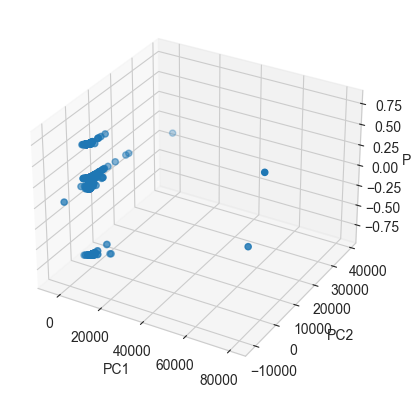

In [17]:
import matplotlib.pyplot as plt

# Assuming transformed_data is your DataFrame with PCA features
pca_features = transformed_data.select("pca_features").collect()

# Extracting PCA feature values
pca_values = [row.pca_features.toArray() for row in pca_features]

# Creating a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extracting PCA components
x = [val[0] for val in pca_values]
y = [val[1] for val in pca_values]
z = [val[2] for val in pca_values]

# Plotting data points
ax.scatter(x, y, z)

# Setting labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Displaying the plot
plt.show()


To explore further opportunities in dimensionality reduction, please look at:
https://spark.apache.org/docs/latest/mllib-dimensionality-reduction.html


## Basic Statistics

Let's demonstrate how to perform correlation analysis.

**Reminder**: Correlation analysis is a statistical technique used to quantify the degree to which two or more variables are related to each other. It helps identify patterns, relationships, and dependencies between different variables in a dataset. Correlation analysis is essential for understanding the interdependencies between features and for feature selection in machine learning models.

In [18]:
from pyspark.ml.stat import Correlation

# Compute the correlation matrix for the "features" column
corr_matrix = Correlation.corr(transformedTraining, "features").head()

# Extract the correlation matrix as a DenseMatrix
corr_matrix_values = corr_matrix[0].toArray()

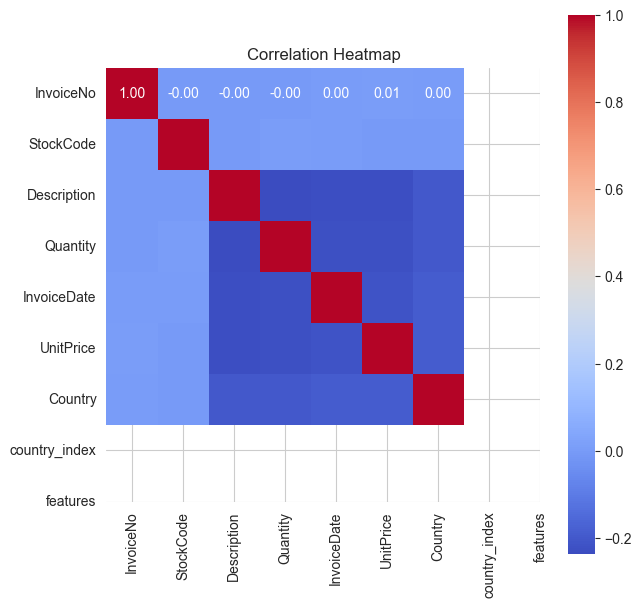

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap using Seaborn
plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix_values, annot=True, cmap="coolwarm", fmt=".2f", square=True,
            xticklabels=transformedTraining.columns, yticklabels=transformedTraining.columns)

plt.title("Correlation Heatmap")
plt.show()

To explore further opportunities in statistics, please look at:
 https://spark.apache.org/docs/latest/ml-statistics.html

In [84]:
# Do not forget to release the resources held by Spark
spark.stop()